Follows the tutorial at: https://www.kaggle.com/code/dansbecker/shap-values/tutorial

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('./FIFA 2018 Statistics.csv')
data

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,11-07-2018,England,Croatia,1,46,11,1,6,4,4,...,1,0,0,No,5.0,Semi- Finals,No,0,NaN,NaN
124,14-07-2018,Belgium,England,2,43,12,4,3,5,4,...,1,0,0,Yes,4.0,3rd Place,No,0,NaN,NaN
125,14-07-2018,England,Belgium,0,57,15,5,7,3,5,...,2,0,0,No,NaN,3rd Place,No,0,NaN,NaN
126,15-07-2018,France,Croatia,4,39,8,6,1,1,2,...,2,0,0,Yes,18.0,Final,No,0,1.0,18.0


In [3]:
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]] # Note we only extract numerical features
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)
my_model

RandomForestClassifier(random_state=0)

In [35]:
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((96, 18), (32, 18), (96,), (32,))

Note we only extract numerical features to build the model.

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.

In [4]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.29, 0.71]])

The team is 70% likely to have a player win the award.

Now, we'll move onto the code to get SHAP values for that single prediction.`

In [6]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap_values

[array([-0.10282092,  0.04740467, -0.02983219, -0.02277977, -0.00642731,
        -0.01258714, -0.02910577,  0.00766886, -0.00792221, -0.01031725,
         0.00500036,  0.00094579,  0.02061101, -0.04846459, -0.00601652,
        -0.00042073, -0.0008261 , -0.01286019]),
 array([ 0.10282092, -0.04740467,  0.02983219,  0.02277977,  0.00642731,
         0.01258714,  0.02910577, -0.00766886,  0.00792221,  0.01031725,
        -0.00500036, -0.00094579, -0.02061101,  0.04846459,  0.00601652,
         0.00042073,  0.0008261 ,  0.01286019])]

In [32]:
data_for_prediction

Goal Scored                 2
Ball Possession %          38
Attempts                   13
On-Target                   7
Off-Target                  4
Blocked                     2
Corners                     6
Offsides                    1
Free Kicks                 18
Saves                       1
Pass Accuracy %            69
Passes                    399
Distance Covered (Kms)    148
Fouls Committed            25
Yellow Card                 1
Yellow & Red                0
Red                         0
Goals in PSO                3
Name: 118, dtype: int64

In [33]:
data_for_prediction.shape

(18,)

In [34]:
type(data_for_prediction)

pandas.core.series.Series

The shap_values object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes (pulling out shap_values[1]).

It's cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.



In [7]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [9]:
explainer.expected_value

array([0.49875, 0.50125])

In [8]:
data_for_prediction

Goal Scored                 2
Ball Possession %          38
Attempts                   13
On-Target                   7
Off-Target                  4
Blocked                     2
Corners                     6
Offsides                    1
Free Kicks                 18
Saves                       1
Pass Accuracy %            69
Passes                    399
Distance Covered (Kms)    148
Fouls Committed            25
Yellow Card                 1
Yellow & Red                0
Red                         0
Goals in PSO                3
Name: 118, dtype: int64

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in shap.TreeExplainer(my_model). But the SHAP package has explainers for every type of model.

* shap.DeepExplainer works with Deep Learning models.
* shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

Here is an example using KernelExplainer to get similar results. The results aren't identical because KernelExplainer gives an approximate result. But the results tell the same story.

In [10]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

# Summary plots

The below follows the tutorial at: https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values

Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

* a large effect for a few predictions, but no effect in general, or
* a medium effect for all predictions.

Solution: SHAP summary plots

# Summary Plots in Code

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [13]:
data = pd.read_csv('./FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)
my_model

RandomForestClassifier(random_state=0)

We get the SHAP values for all validation data with the following code. It is short enough that we explain it in the comments.

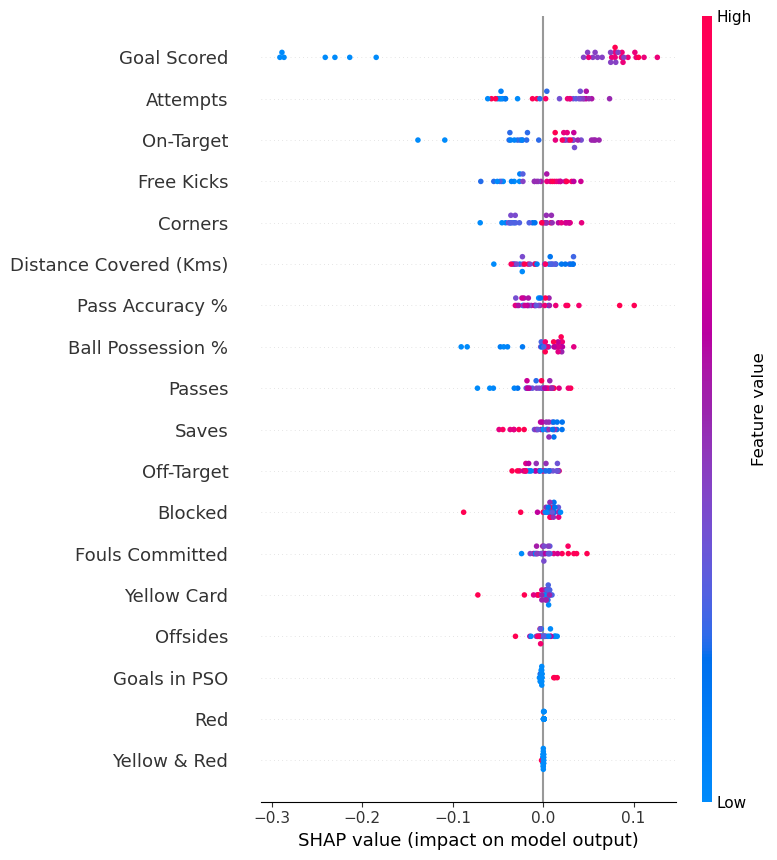

In [14]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

In [16]:
val_X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
121,0,60,9,3,5,1,5,1,7,4,90,629,102,16,3,0,0,0
104,2,47,21,10,7,4,8,0,20,1,83,398,92,6,2,0,0,0
55,2,59,13,5,6,2,5,0,24,5,89,485,97,7,0,0,0,0
56,2,71,16,5,4,7,8,5,15,5,91,699,111,12,0,1,0,0
33,1,53,13,1,8,4,4,0,11,1,81,438,110,10,1,0,0,0
118,2,38,13,7,4,2,6,1,18,1,69,399,148,25,1,0,0,3
122,2,54,22,7,11,4,8,1,17,0,79,622,143,23,2,0,0,0
35,0,53,16,4,10,2,7,1,20,1,77,466,107,23,1,0,0,0
31,2,43,8,2,4,2,3,3,11,3,81,328,107,15,2,0,0,0
51,2,58,20,5,8,7,7,3,17,2,87,547,112,12,1,0,0,0


In [22]:
shap_values[1]

array([[-2.14045350e-01,  2.11501004e-02, -4.66721751e-02,
        -2.28475677e-02,  1.08748824e-02,  1.92050793e-02,
         3.46666728e-03,  4.41675941e-04, -3.20476249e-02,
        -2.89423189e-03,  1.00742194e-01,  2.77881175e-02,
         1.40882409e-02,  2.55323026e-03, -1.52616934e-03,
         4.84691547e-05,  4.00852716e-04, -1.97639121e-03],
       [ 8.83391460e-02,  2.00116905e-02,  2.76173642e-03,
         1.32580228e-02, -8.07933902e-03,  1.10261221e-02,
         2.01306572e-02,  8.01843773e-03,  2.54964442e-02,
         1.17154873e-02, -1.78164245e-02, -4.41079660e-03,
        -5.46251446e-02, -8.57632567e-03,  2.61282228e-03,
         1.52447356e-04,  9.85215282e-04, -2.25019885e-03],
       [ 7.57556968e-02,  1.38656436e-02,  4.10659229e-02,
         5.34750073e-02,  7.84091722e-03,  1.28944568e-02,
         9.91930022e-03, -2.58313452e-03,  1.01171521e-02,
        -4.88233879e-02,  2.52599033e-02,  8.08380312e-03,
        -3.34446095e-02, -2.47304746e-03,  8.13289379e

In [25]:
len(shap_values)

2

In [26]:
shap_values[1].shape

(32, 18)

The rows above represents each of the 32 samples, the columns represents the 18 features

In [27]:
val_X.shape

(32, 18)

# SHAP Dependence Contribution Plots

Unlike partial dependence plots, SHAP dependence contribution plots show the distribution of effects. Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

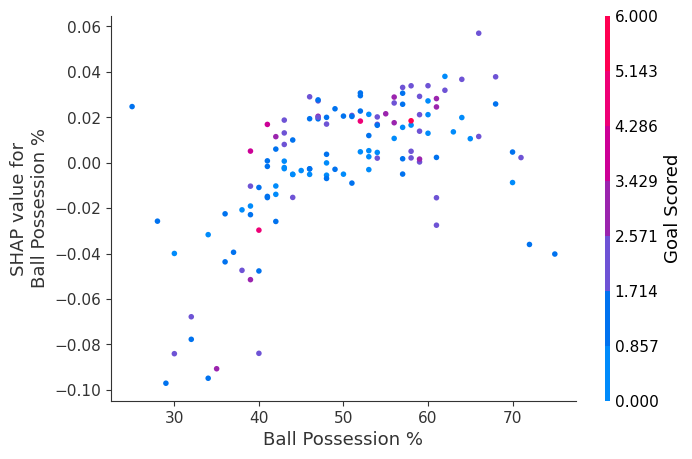

In [28]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

In [29]:
X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,46,11,1,6,4,4,3,24,5,79,479,148,14,1,0,0,0
124,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,0
125,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,0
126,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,0


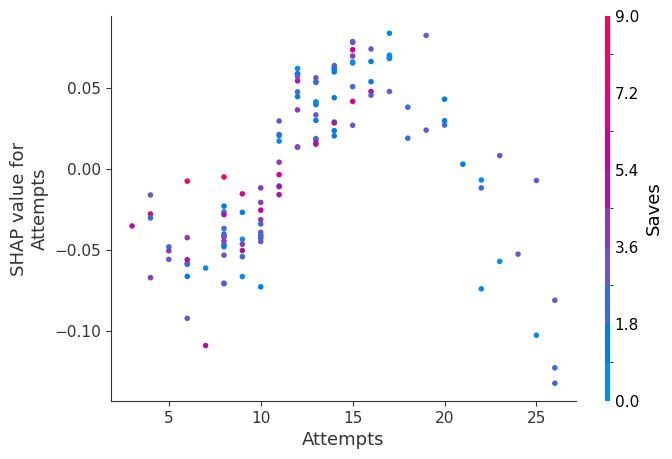

In [31]:
# make plot.
shap.dependence_plot('Attempts', shap_values[1], X)